# Series de tiempo y redes neuronales.

Hay varias maneras de usar redes neuronales para predecir series de tiempo. Nuestro objetivo será llegar a redes neuronales recurrentes, pero iremos explorando las ideas poco a poco.

Seguiremos usando la serie de tiempo de las temperaturas. Ustedes tendrán que repetir esto con alguna serie de tiempo interesante (e.g. coronavirus?).

In [1]:
import numpy as np
import pandas as pd
import fastai.basics as fai
import fastai.tabular as ftab
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
df = pd.read_csv("TimeSeries/daily-min-temperatures.csv",index_col='Date',parse_dates=True)

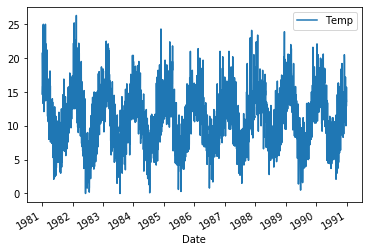

In [3]:
df.plot()

## ¿Cómo usar redes neuronales?

Hay muchas cosas que podemos hacer para usar redes neuronales en series de tiempo. Vamos a empezar por lo más más sencillo y poco a poco iremos agregando cosas. El plan será:

1. Que la red tome exclusivamente la temperatura del día anterior para predecir la temperatura del día siguiente.
2. Convolucionales: Agregarle las últimas $k$ temperaturas para que pueda hacer la predicción.
3. Agregarle información del mes y del año.
4. Agregarle por ejemplo la EWMA.
5. Agregarle la desviación estándar, y otra información.
6. ¿Por qué redes recurrentes?


### Cargando los datos

Recordemos que fastai puede cargar datos "tabulares" (e.g. un dataframe de pandas).

In [4]:
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


Queremos predecir la temperatura cada día basados en la temperatura anterior, así que debemos crear la columna "ultima_temp".

In [5]:
df['ultima_temp'] = df['Temp'].shift(1)

In [6]:
df.head()

,Temp,ultima_temp
Date,,
1981-01-01,20.7,NaN
1981-01-02,17.9,20.7
1981-01-03,18.8,17.9
1981-01-04,14.6,18.8
1981-01-05,15.8,14.6


In [7]:
def error_l1(df,colA,colB):
    valid_df = df[3000:]
    return np.mean(np.abs(valid_df[colA]-valid_df[colB]))
def error_rmse(df,colA,colB):
    valid_df = df[3000:]
    return np.sqrt(np.mean(np.square(valid_df[colA]-valid_df[colB])))

In [8]:
error_l1(df,'Temp','ultima_temp')

1.9816923076923065

In [9]:
error_rmse(df,'Temp','ultima_temp')

2.5210589960448093

In [10]:
df.dropna(inplace=True)

In [11]:
def cargar_datos(df,batch_size=128):
    n = len(df)
    valid_num = int(0.1*n)
    valid_idx = list(range(n-valid_num,n))
    return (ftab.TabularList
                .from_df(df, path='.', cont_names=['ultima_temp'], procs=[])
                .split_by_idx(valid_idx)
                .label_from_df(cols=['Temp'])
                .databunch(path='.', bs=batch_size, num_workers=8))

In [12]:
data = cargar_datos(df)

In [13]:
x,y=data.one_batch()

In [ ]:
x

No se preocupen por el tensor de 0's. Lo que ocurre es que fastai divide en datos categóricos y datos contínuos. Sin embargo, ahora no tenemos ningún dato categórico (luego tendremos), así que simplemente me da 0's en los categóricos. No usaremos eso por ahora.

In [ ]:
y

In [ ]:
learn=ftab.tabular_learner(data,layers=[],loss_func=F.l1_loss)

In [ ]:
learn.lr_find(); learn.recorder.plot()

Ese warning no nos gusta. Tendremos que hacer nuestra propia loss func.

In [14]:
def l1_loss_flat(pred,targ):
    #print(pred.shape)
    #print(targ.shape)
    #print("------")
    return F.l1_loss(pred.squeeze(),targ.squeeze())

In [15]:
def rmse_loss_flat(pred,targ):
    return torch.sqrt(F.mse_loss(pred.squeeze(),targ.squeeze()))

In [16]:
learn=ftab.tabular_learner(data,layers=[],loss_func=l1_loss_flat,metrics=rmse_loss_flat)

In [17]:
learn.fit_one_cycle(10,1e-1)

epoch,train_loss,valid_loss,rmse_loss_flat,time
0,10.837839,11.242955,11.613820,00:00
1,9.655787,5.985152,6.450131,00:00
2,6.118458,2.086124,2.583863,00:00
3,4.267069,1.927136,2.425001,00:00
4,3.312786,1.934960,2.428036,00:00
5,2.777918,1.931153,2.426514,00:00
6,2.483434,1.947315,2.439394,00:00
7,2.298144,1.949186,2.442575,00:00
8,2.194622,1.946481,2.439535,00:00
9,2.134379,1.940388,2.433151,00:00


Más o menos tiene el mismo error que la baseline (poquito mejor), lo cual es bueno! Vamos a ver si podemos hacerlo mejor con más capas.

In [18]:
learn=ftab.tabular_learner(data,layers=[128],loss_func=l1_loss_flat,metrics=rmse_loss_flat)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


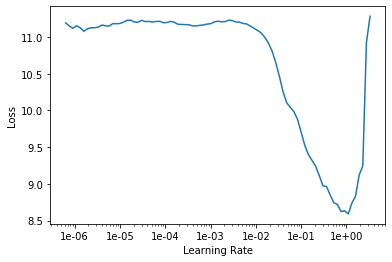

In [19]:
learn.lr_find(); learn.recorder.plot()

In [20]:
learn.fit_one_cycle(15,3e-2)

epoch,train_loss,valid_loss,rmse_loss_flat,time
0,10.992314,10.693395,10.985319,00:00
1,8.410756,3.521725,4.115240,00:00
2,5.380023,2.576639,3.184747,00:00
3,3.888916,2.028377,2.535262,00:00
4,3.115415,1.975391,2.464755,00:00
5,2.686349,1.948291,2.439604,00:00
6,2.452588,1.912864,2.399260,00:00
7,2.302382,2.168087,2.669042,00:00
8,2.222006,1.950108,2.431086,00:00
9,2.153125,1.930188,2.432678,00:00


En realidad no mucho. Pues es que piénsenlo: nada más le dimos la temperatura anterior. Cómo le va a hacer para hacerlo mejor?

## Redes convolucionales.

Si en vez de darle la temperatura anterior le damos las $k$ anteriores, ¿podremos mejorarlo?

In [21]:
df = pd.read_csv("TimeSeries/daily-min-temperatures.csv",index_col='Date',parse_dates=True)

In [22]:
k = 10
for i in range(1,k+1):
    df[f'ultima_{i}'] = df['Temp'].shift(i)

In [23]:
df

,Temp,ultima_1,ultima_2,ultima_3,ultima_4,ultima_5,ultima_6,ultima_7,ultima_8,ultima_9,ultima_10
Date,,,,,,,,,,,
1981-01-01,20.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-02,17.9,20.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-03,18.8,17.9,20.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-04,14.6,18.8,17.9,20.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-05,15.8,14.6,18.8,17.9,20.7,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1990-12-27,14.0,14.6,12.9,10.0,13.9,13.2,13.1,15.4,14.7,17.2,13.9
1990-12-28,13.6,14.0,14.6,12.9,10.0,13.9,13.2,13.1,15.4,14.7,17.2
1990-12-29,13.5,13.6,14.0,14.6,12.9,10.0,13.9,13.2,13.1,15.4,14.7


In [24]:
df.dropna(inplace=True)

In [25]:
def cargar_datos(df,batch_size=128):
    n = len(df)
    valid_num = int(0.1*n)
    valid_idx = list(range(n-valid_num,n))
    return (ftab.TabularList
                .from_df(df, path='.', cont_names=[f'ultima_{i}' for i in range(1,k+1)], procs=[])
                .split_by_idx(valid_idx)
                .label_from_df(cols=['Temp'])
                .databunch(path='.', bs=batch_size, num_workers=8))

In [26]:
data = cargar_datos(df)

In [46]:
learn=ftab.tabular_learner(data,layers=[128,64,32,16],loss_func=l1_loss_flat,metrics=rmse_loss_flat)

In [47]:
learn.fit_one_cycle(12,3e-2)

epoch,train_loss,valid_loss,rmse_loss_flat,time
0,11.120298,11.169464,11.507473,00:00
1,10.204822,6.559134,7.284224,00:00
2,6.660261,6.753031,7.582193,00:00
3,4.519501,2.119971,2.685596,00:00
4,3.419921,1.759146,2.264550,00:00
5,2.801016,1.728689,2.244849,00:00
6,2.457023,1.731179,2.255251,00:00
7,2.249286,1.812212,2.322531,00:00
8,2.115690,1.760394,2.286654,00:00
9,2.028183,1.704317,2.208479,00:00


In [45]:
df

,Temp,ultima_1,ultima_2,ultima_3,ultima_4,ultima_5,ultima_6,ultima_7,ultima_8,ultima_9,ultima_10
Date,,,,,,,,,,,
1981-01-11,16.2,20.0,21.8,17.4,15.8,15.8,15.8,14.6,18.8,17.9,20.7
1981-01-12,13.3,16.2,20.0,21.8,17.4,15.8,15.8,15.8,14.6,18.8,17.9
1981-01-13,16.7,13.3,16.2,20.0,21.8,17.4,15.8,15.8,15.8,14.6,18.8
1981-01-14,21.5,16.7,13.3,16.2,20.0,21.8,17.4,15.8,15.8,15.8,14.6
1981-01-15,25.0,21.5,16.7,13.3,16.2,20.0,21.8,17.4,15.8,15.8,15.8
...,...,...,...,...,...,...,...,...,...,...,...
1990-12-27,14.0,14.6,12.9,10.0,13.9,13.2,13.1,15.4,14.7,17.2,13.9
1990-12-28,13.6,14.0,14.6,12.9,10.0,13.9,13.2,13.1,15.4,14.7,17.2
1990-12-29,13.5,13.6,14.0,14.6,12.9,10.0,13.9,13.2,13.1,15.4,14.7


# Modelo

Estamos usando una red neuronal "fully connected":

In [41]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)

- embeds es vacío porque no tenemos variables categóricas.
- emb_drop es el embedding dropout. Podemos agregarle si queremos.
- bn_cont es la capa batchnorm que le aplicamos a las cariables continuas. En este caso solo tenemos una variable.
- layers son las capas que le dijimos.

Podemos modificarla como normalmente hacemos. Por ejemplo:

In [42]:
learn.model.layers[1] = nn.LeakyReLU(inplace=True)

In [43]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)

## Ejercicios

Ejercicio 1: Agrega información de año y mes, y agrega el EWMA también. Repite todo a ver si llegas a menos.

Ejercicio 2: Repite esto con alguna otra serie de tiempo.